In [5]:
import plotly
import seaborn as sns
# from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

%matplotlib inline

#todo: 
csv for each cuisine, 
graphing in this enviro, (run other pyplot examples, see if they work, what do they import?)
logistic regession, 
taking spaces out of middle (replace with underscore)
display notebook on webpage (git hub link)

In [10]:
# import matplotlib.pyplot as plt
# from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import os
import numpy as np

In [21]:
#load clean CSVs 
train_clean_df = pd.read_csv('train_clean_data.csv')
train_clean_df.head()

,id,cuisine,text,category_id
0,10259,greek,"romaine_lettuce,black_olives,grape_tomatoes,ga...",0
1,25693,southern_us,"plain_flour,ground_pepper,salt,tomatoes,ground...",1
2,22213,indian,"water,vegetable_oil,wheat,salt",2
3,13162,indian,"black_pepper,shallots,cornflour,cayenne_pepper...",2
4,42779,spanish,"olive_oil,salt,medium_shrimp,pepper,garlic,cho...",3


Machine Learning:

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer 
 
tfidf_vectorizer=TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', stop_words='english') 
# tfidf_vectorizer=TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english') 
# just send in all your docs here 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(train_clean_df.text)

# get the first vector out (for the first document) 
first_vector_tfidfvectorizer = tfidf_vectorizer_vectors[0] 


In [23]:
# place tf-idf values in a pandas data frame 
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df = df.sort_values(by=["tfidf"],ascending=False)
df.head(10)

,tfidf
garbanzo_beans,0.417649
seasoning,0.408356
black_olives,0.374864
grape_tomatoes,0.372952
romaine_lettuce,0.362357
feta_cheese_crumbles,0.346146
purple_onion,0.247102
pepper,0.198735
garlic,0.165902
pickled_vegetables,0.000000


In [24]:
features = tfidf_vectorizer.fit_transform(train_clean_df.text).toarray()
labels = train_clean_df.category_id
features.shape

(36716, 3262)

Now, each of 4569 consumer complaint narratives is represented by 12633 features, representing the tf-idf score for different unigrams and bigrams.

In [25]:
# train_clean_df['category_id'] = train_clean_df['cuisine'].factorize()[0]
category_id_df = train_clean_df[['cuisine', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'cuisine']].values)
train_clean_df.head()

,id,cuisine,text,category_id
0,10259,greek,"romaine_lettuce,black_olives,grape_tomatoes,ga...",0
1,25693,southern_us,"plain_flour,ground_pepper,salt,tomatoes,ground...",1
2,22213,indian,"water,vegetable_oil,wheat,salt",2
3,13162,indian,"black_pepper,shallots,cornflour,cayenne_pepper...",2
4,42779,spanish,"olive_oil,salt,medium_shrimp,pepper,garlic,cho...",3


In [64]:
# for cuisine, category_id in sorted(category_to_id.items()):
#     features_chi2 = chi2(features, labels == category_id)
#     indices = np.argsort(features_chi2[0])
#     feature_names = np.array(tfidf_vectorizer.get_feature_names())[indices]
#     unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

In [60]:
from sklearn.feature_selection import chi2
# import numpy as np

N = 2
for cuisine, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vectorizer.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    list = unigrams[-N:]
    cuisine_df = pd.DataFrame(unigrams[-N:], columns=['Ingredient'])
    data_folder = os.path.join("cuisine_top_ingredients_data")
    filename = os.path.join(data_folder, cuisine + '_ingredients.csv')
    cuisine_df.to_csv(filename, index=False)
    print (cuisine + ':' + str(list))
print("csv's saved")

british:['stilton_cheese', 'beef_drippings']
cajun_creole:['andouille_sausage', 'cajun_seasoning']
chinese:['corn_starch', 'soy_sauce']
french:['gruyere_cheese', 'large_egg_yolks']
greek:['feta_cheese', 'feta_cheese_crumbles']
indian:['ground_turmeric', 'garam_masala']
irish:['corned_beef', 'irish_whiskey']
italian:['fresh_basil', 'grated_parmesan_cheese']
japanese:['sake', 'mirin']
korean:['kimchi', 'gochujang_base']
mexican:['salsa', 'corn_tortillas']
southern_us:['baking_powder', 'buttermilk']
spanish:['saffron_threads', 'spanish_chorizo']
thai:['coconut_milk', 'fish_sauce']
vietnamese:['rice_vermicelli', 'fish_sauce']


detour for matching with spoonacular api

In [61]:
cuisine_df

,Ingredient
0,rice_vermicelli
1,fish_sauce


In [ ]:
#load spoon CSVs 
train_clean_df = pd.read_csv('train_clean_data.csv')
train_clean_df.head()

end detour

In [27]:
from sklearn.feature_selection import chi2
import numpy as np
N = 3
for cuisine, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf_vectorizer.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(cuisine))
    print("  . Most correlated:\n. {}".format('\n. '.join(unigrams[-N:])))
#     print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'british':
  . Most correlated:
. golden_syrup
. stilton_cheese
. beef_drippings
# 'cajun_creole':
  . Most correlated:
. creole_seasoning
. andouille_sausage
. cajun_seasoning
# 'chinese':
  . Most correlated:
. sesame_oil
. corn_starch
. soy_sauce
# 'french':
  . Most correlated:
. unsalted_butter
. gruyere_cheese
. large_egg_yolks
# 'greek':
  . Most correlated:
. fresh_dill
. feta_cheese
. feta_cheese_crumbles
# 'indian':
  . Most correlated:
. cumin_seed
. ground_turmeric
. garam_masala
# 'irish':
  . Most correlated:
. guinness_beer
. corned_beef
. irish_whiskey
# 'italian':
  . Most correlated:
. parmesan_cheese
. fresh_basil
. grated_parmesan_cheese
# 'japanese':
  . Most correlated:
. dashi
. sake
. mirin
# 'korean':
  . Most correlated:
. sesame_seeds
. kimchi
. gochujang_base
# 'mexican':
  . Most correlated:
. avocado
. salsa
. corn_tortillas
# 'southern_us':
  . Most correlated:
. grits
. baking_powder
. buttermilk
# 'spanish':
  . Most correlated:
. sherry_vinegar
. saf

Model:

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(train_clean_df['text'], train_clean_df['cuisine'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
    ,LinearSVC()
    ,MultinomialNB()
#     ,LogisticRegression(random_state=0) #gradient decent wasn't able to converg given these inputs
]
CV = 5 #crossvalidation
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

In [41]:
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    print("done with" + model)
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

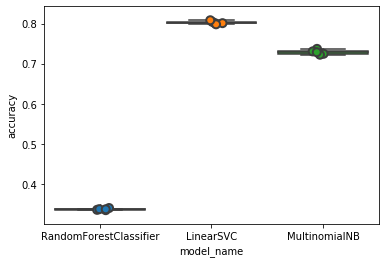

In [42]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [43]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.802457
MultinomialNB             0.728620
RandomForestClassifier    0.337564
Name: accuracy, dtype: float64